<a href="https://colab.research.google.com/github/psgrigoletti/margem-liquida-colab/blob/main/2022_07_16_Analisando_a_inflacao_no_Brasil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Dados da Inflação utilizando o Python

A inflação é conhecida como o termo que representa a taxa de crescimento do nível geral de preços entre dois períodos distintos. No Brasil, o indicador que consolidou-se como o principal índice de preços é o Índice de Preços ao Consumidor Amplo (IPCA), divulgado pelo IBGE e amplamente utilizado pela autoridade monetária como referência para realizar o controle da inflação.


O IPCA é divulgado mensalmente pelo IBGE, portanto, podemos importar diretamente do SIDRA os dados do indicador utilizando a biblioteca {sidrapy}. Primeiro, iremos buscar a série que diz respeito a variação mensal, acumulada em 3 meses, acumulada em 6 meses, acumulada em 12 meses e acumulado no ano, que diz respeito a tabela 1737.


Em um segundo momento, buscaremos a série de pesos e variação de cada grupo do IPCA, e veremos a contribuição de cada grupo sobre o IPCA, através da tabela 7060.


Para importar as séries com a função get_table do {sidrapy}, buscamos a API das tabelas, com os parâmetros configurados, de forma a obter os códigos. Ensinamos este processo em um post anterior: Coletando dados do SIDRA com o Python.


In [ ]:
# Importa as bibliotecas necessárias
!pip install sidrapy
import sidrapy

import numpy as np
import pandas as pd

import datetime as dt

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# Importa as variações do IPCA
ipca_raw = sidrapy.get_table(table_code = '1737',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,69,2263,2264,2265',
                             period = 'last%20472')

In [3]:
# Realiza a limpeza e manipulação da tabela
ipca =  (ipca_raw.loc[1:,['V', 'D2C', 'D3N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable'})
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'Var. mensal (%)',
                                                        'IPCA - Variação acumulada no ano': 'Var. acumulada no ano (%)', 
                                                        'IPCA - Variação acumulada em 3 meses' : 'Var. MM3M (%)',
                                                        'IPCA - Variação acumulada em 6 meses': 'Var. MM6M (%)',
                                                        'IPCA - Variação acumulada em 12 meses' : 'Var. MM12M (%)'}),
            date  = lambda x: pd.to_datetime(x['date'], format = "%Y%m"),
            value = lambda x: x['value'].astype(float))
    .pipe(lambda x: x.loc[x.date > '2007-01-01']))

In [16]:
# Configura o tema do gráfico
## Cores
colors = ['#282f6b', '#b22200', '#eace3f', '#224f20', '#b35c1e', '#419391', '#839c56','#3b89bc']

## Tamanho
theme = {'figure.figsize' : (15, 10)}

## Aplica o tema
sns.set_theme(rc = theme, palette = colors)

Text(1.0, -0.08, 'Fonte: dados do Sidra/IBGE')

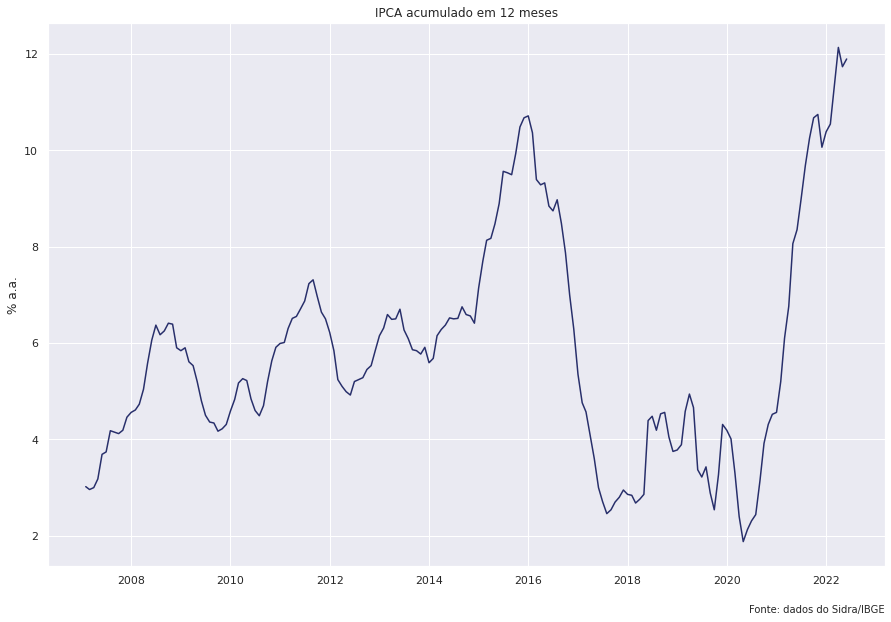

In [18]:
# Filtra somente para o IPCA acumulado em 12 meses
ipca_12m = (   
            ipca
            .pipe(lambda x: x.loc[x.variable == 'Var. MM12M (%)'])
           )

# Plota o IPCA acumulado em 12 meses
sns.lineplot(x = 'date',
             y = 'value',
             data = ipca_12m).set(title = 'IPCA acumulado em 12 meses',
                                                           xlabel = '',
                                                           ylabel = '% a.a.')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: dados do Sidra/IBGE',
            xy = (1.0, -0.08),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

Text(1.0, -0.13, 'Fonte: analisemacro.com.br com dados do Sidra/IBGE')

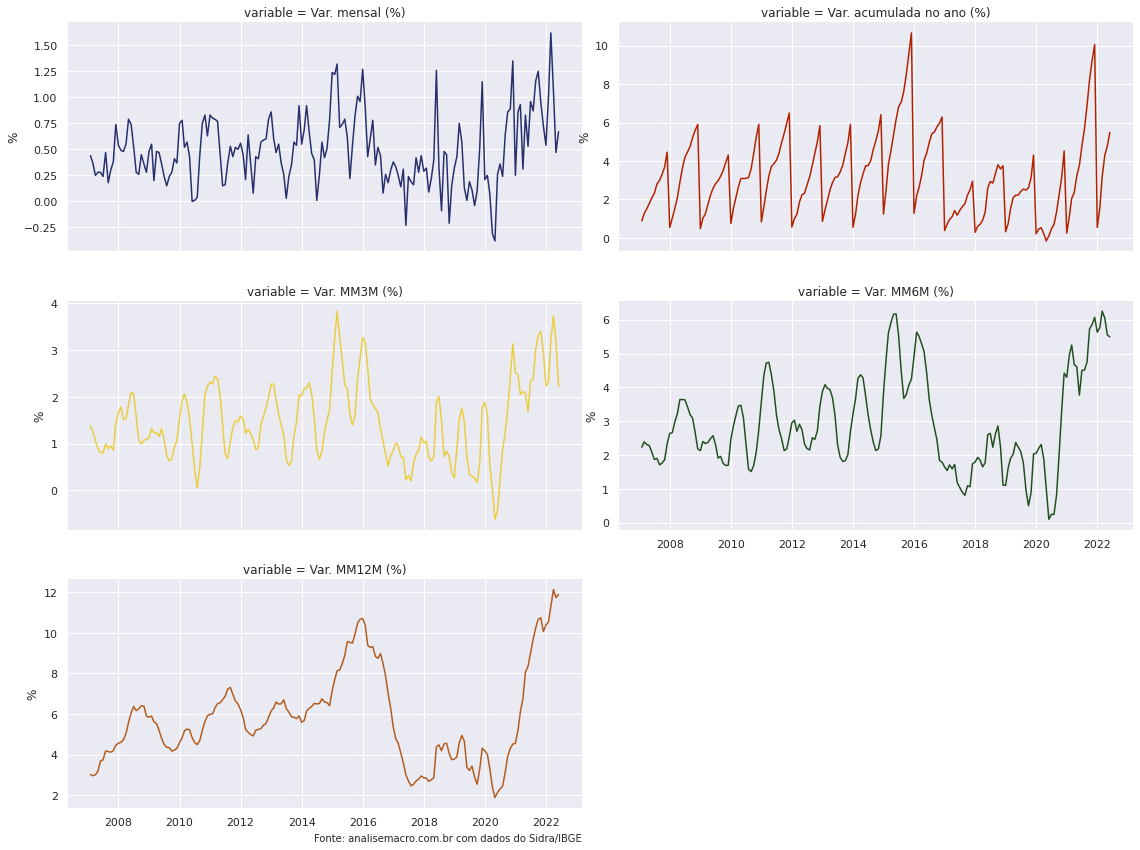

In [19]:
# Plota todas as variações
g = sns.FacetGrid(ipca, col = 'variable',
                  col_wrap = 2,
                  hue = 'variable',
                  sharey = False,
                  height = 4,
                  aspect = 2)


g.map_dataframe(sns.lineplot, 
                x = 'date',
                y = 'value').set(xlabel = "",
                                 ylabel = '%')

# Adiciona a fonte no gráfico           
plt.annotate('Fonte: analisemacro.com.br com dados do Sidra/IBGE',
            xy = (1.0, -0.13),
            xycoords='axes fraction',
            ha='right',
            va="center",
            fontsize=10)

# IPCA Contribuição por grupo: tabela 7060

In [10]:
# Importa as variações e os pesos dos grupos do IPCA
ipca_gp_raw = sidrapy.get_table(table_code = '7060',
                             territorial_level = '1',
                             ibge_territorial_code = 'all',
                             variable = '63,66',
                             period = 'all',
                             classification = '315/7170,7445,7486,7558,7625,7660,7712,7766,7786'
                             )

In [11]:
# Realiza a limpeza e manipulação da tabela
ipca_gp =  (
    ipca_gp_raw
    .loc[1:,['V', 'D2C', 'D3N', 'D4N']]
    .rename(columns = {'V': 'value',
                       'D2C': 'date',
                       'D3N': 'variable',
                       'D4N': 'groups'})
    .assign(variable = lambda x: x['variable'].replace({'IPCA - Variação mensal' : 'variacao',
                                                        'IPCA - Peso mensal': 'peso'}),
            date  = lambda x: pd.to_datetime(x['date'],
                                              format = "%Y%m"),
            value = lambda x: x['value'].astype(float),
            groups = lambda x: x['groups'].astype(str)
           )
    .pipe(lambda x: x.loc[x.date > '2007-01-01'])
        )

In [12]:
# Torna em formato wide e calcula a contribuição de cada grupo pro IPCA
ipca_gp_wider = (
    ipca_gp
    .pivot_table(index = ['date', 'groups'],
                 columns = 'variable',
                 values = 'value')
    .reset_index()
    .assign(contribuicao = lambda x: (x.peso * x.variacao) / 100)
                )

In [ ]:
# Importa a biblioteca plotly
!pip install plotly
import plotly.express as px

In [14]:
# Plota a contribuição de cada grupo com plotly
px.bar(ipca_gp_wider,
       x = 'date',
       y = 'contribuicao',
       color = 'groups',
       color_discrete_sequence = colors)